# Verification

In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sithom.plot import plot_defaults, label_subplots
from sithom.time import timeit
from src.conversions import si_ify, knots_to_ms
from src.constants import KATRINA_ERA5_NC, KATRINA_TIDE_NC, KAT_EX_PATH, NO_BBOX
from src.data_loading.ibtracs import kat_stats, katrina
from adcircpy.outputs import Maxele

/Users/simon/new-orleans/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
@np.vectorize
def indices_in_bbox(lon, lat):
    return (
        lon > NO_BBOX.lon[0]
        and lon < NO_BBOX.lon[1]
        and lat > NO_BBOX.lat[0]
        and lat < NO_BBOX.lat[1]
    )

## Tide Stations

In [7]:
tide_ds = xr.open_dataset(KATRINA_TIDE_NC)
tide_ds

<xarray.Dataset>
Dimensions:      (date_time: 3121, stationid: 7)
Coordinates:
  * date_time    (date_time) datetime64[ns] 2005-08-20 ... 2005-09-02
    name         (stationid) object ...
  * stationid    (stationid) object '8729840' '8735180' ... '8762482' '8764044'
    lon          (stationid) float64 ...
    lat          (stationid) float64 ...
Data variables:
    flags        (stationid, date_time) object ...
    QC           (stationid, date_time) object ...
    water_level  (stationid, date_time) float64 ...
    sigma        (stationid, date_time) float64 ...

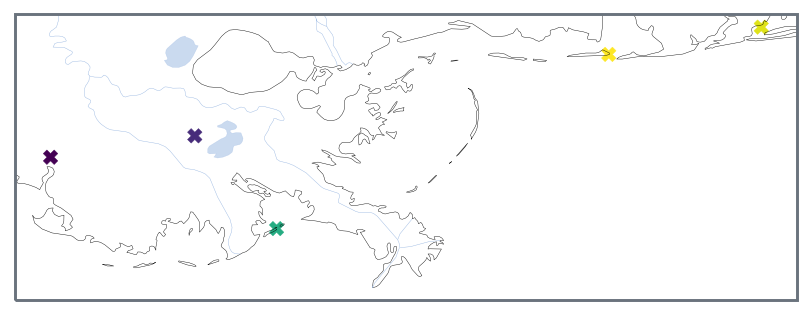

In [10]:
from src.plot.map import map_axes
from sithom.plot import plot_defaults

plot_defaults()
map_axes()
plt.scatter(
    tide_ds.lon.values,
    tide_ds.lat.values,
    c=tide_ds.isel(date_time=2000).water_level.values,
)

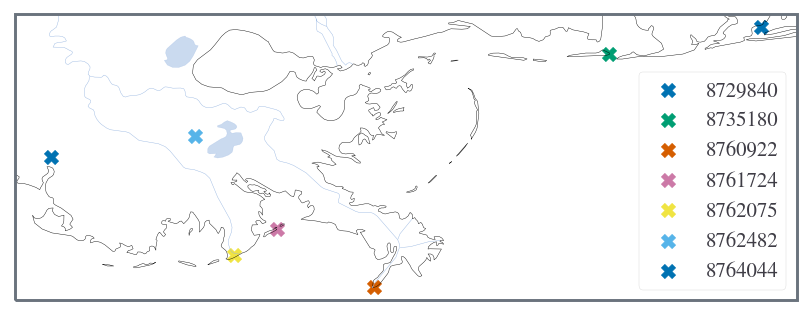

In [11]:
plot_defaults()
map_axes()
for i in range(len(tide_ds.lon.values)):
    tmp_ds = tide_ds.isel(stationid=i)
    plt.scatter(
        tmp_ds.lon.values, tmp_ds.lat.values, label=str(tmp_ds.stationid.values)
    )

plt.legend()

In [18]:
gi = tide_ds.sel(stationid="8761724")
gi

<xarray.Dataset>
Dimensions:      (date_time: 3121)
Coordinates:
  * date_time    (date_time) datetime64[ns] 2005-08-20 ... 2005-09-02
    name         object 'Grand Isle'
    stationid    <U7 '8761724'
    lon          float64 -89.96
    lat          float64 29.26
Data variables:
    flags        (date_time) object '1,0,0,0' '0,0,0,0' ... '0,0,0,0' '1,0,0,0'
    QC           (date_time) object 'v' 'v' 'v' 'v' 'v' ... 'v' 'v' 'v' 'v' 'v'
    water_level  (date_time) float64 -0.239 -0.244 -0.243 ... -0.16 -0.163
    sigma        (date_time) float64 0.0 0.004 0.005 0.004 ... 0.002 0.002 0.0

## Find Corresponding Mesh Point

In [13]:
import os

In [14]:
os.listdir(KAT_EX_PATH)

['minpr.63.nc',
 'maxwvel.63.nc',
 'windDrag.173.nc',
 'fort.73.nc',
 'fort.63.nc',
 'fort.22',
 'fort.14',
 'maxvel.63.nc',
 'fort.15',
 'fort.218',
 'fort.221',
 'fort.217',
 'run.sh',
 'adcirc_log.txt',
 'maxele.63.nc',
 'comparison.log',
 'fort.33',
 'fort.74.nc',
 'fort.64.nc',
 'fort.16',
 'control',
 'fort.224',
 'fort.223',
 'fort.222']

In [15]:
me = Maxele(os.path.join(KAT_EX_PATH, "maxele.63.nc"))

In [17]:
local_indices = indices_in_bbox(me.x, me.y)

In [21]:
global_index = ((gi.lon.values - me.x) ** 2 + (gi.lat.values - me.y) ** 2).argmin()
global_index

4993

In [23]:
local_index = (
    (gi.lon.values - me.x[local_indices]) ** 2
    + (gi.lat.values - me.y[local_indices]) ** 2
).argmin()
local_index

120

In [24]:
print(me.x[global_index], me.y[global_index])
print(gi.lon.values, gi.lat.values)

-89.93858590820001 29.2449848667
-89.957 29.263


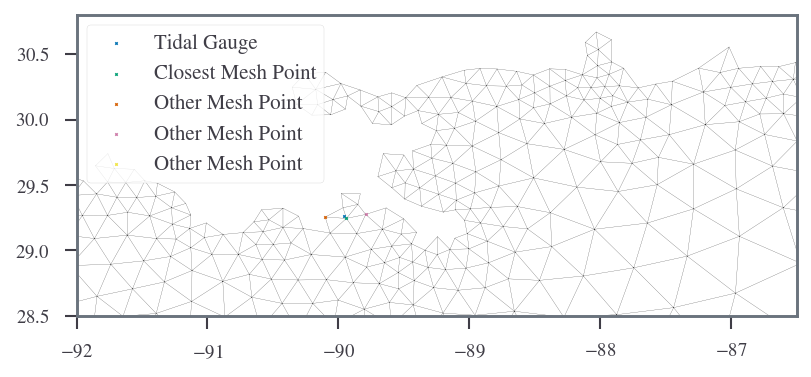

In [69]:
me.triplot()
NO_BBOX.ax_lim(plt.gca())
s = 2
plt.scatter(gi.lon.values, gi.lat.values, label="Tidal Gauge", s=s)
plt.scatter(me.x[global_index], me.y[global_index], label="Closest Mesh Point", s=s)
plt.scatter(
    me.x[global_index + 1],
    me.y[global_index + 1],
    label="Close Coastal Mesh Point",
    s=s,
)
plt.scatter(
    me.x[global_index - 1],
    me.y[global_index - 1],
    label="Close Coastal Mesh Point",
    s=s,
)
plt.scatter(
    me.x[global_index + o],
    me.y[global_index + o],
    label="Close Coastal Mesh Point",
    s=s,
)

plt.legend()

## Comparing ADCIRC exampel Fort.63 file to tidal gauge 

In [25]:
from adcircpy.outputs import Fort63

In [28]:
f63 = Fort63(os.path.join(KAT_EX_PATH, "fort.63.nc"))

Text(0.5, 0, 'Time Index')

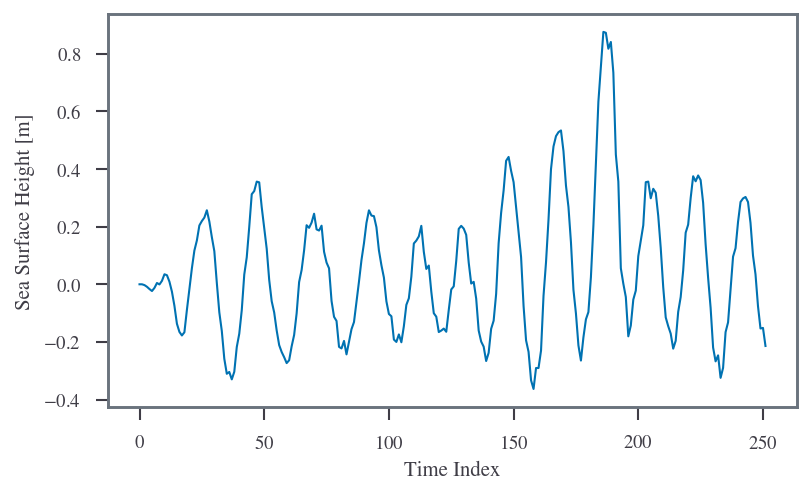

In [50]:
plt.plot(f63._ptr["zeta"][:, global_index])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

Text(0.5, 0, 'Time Index')

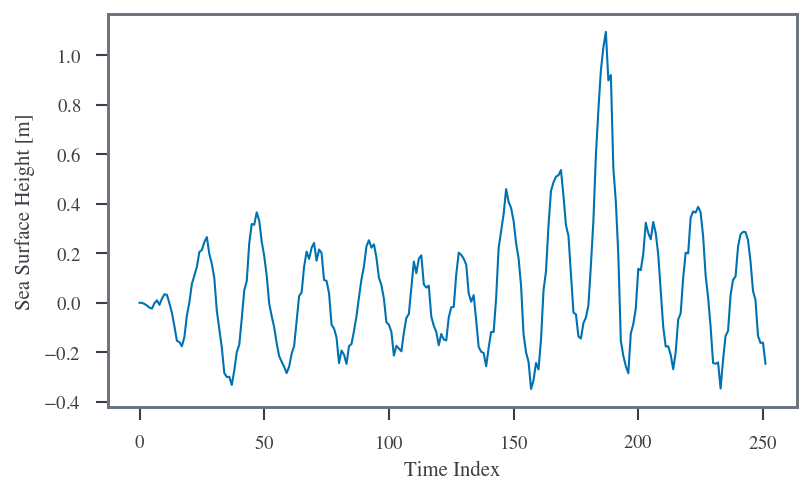

In [51]:
plt.plot(f63._ptr["zeta"][:, global_index - 1])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

Text(0.5, 0, 'Time Index')

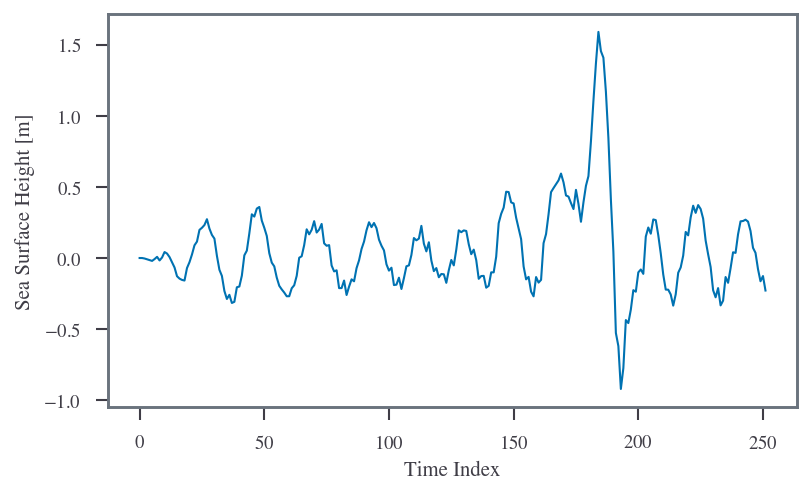

In [52]:
plt.plot(f63._ptr["zeta"][:, global_index + 1])
plt.ylabel("Sea Surface Height [m]")
plt.xlabel("Time Index")

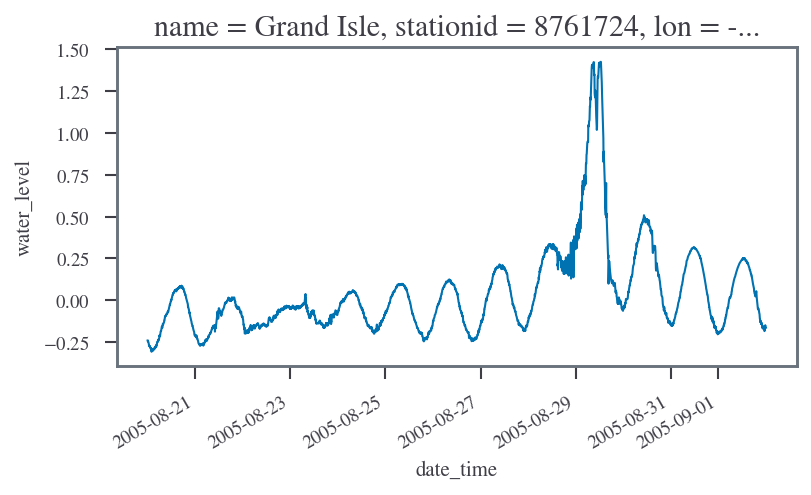

In [31]:
gi.water_level.plot()

## ERA5 run prep

In [71]:
e5 = xr.open_dataset(KATRINA_ERA5_NC)
e5

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 81, time: 408)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -80.5 -80.25 -80.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2005-08-20 ... 2005-09-05T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-28 16:29:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [97]:
from src.constants import MID_KATRINA_TIME
from src.preprocessing.sel import mid_katrina
from sithom.plot import label_subplots, get_dim
from sithom.xr import plot_units
from src.conversions import pascal_to_millibar

/Users/simon/new-orleans/env/lib/python3.8/site-packages/xarray/core/dataarray.py:810: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


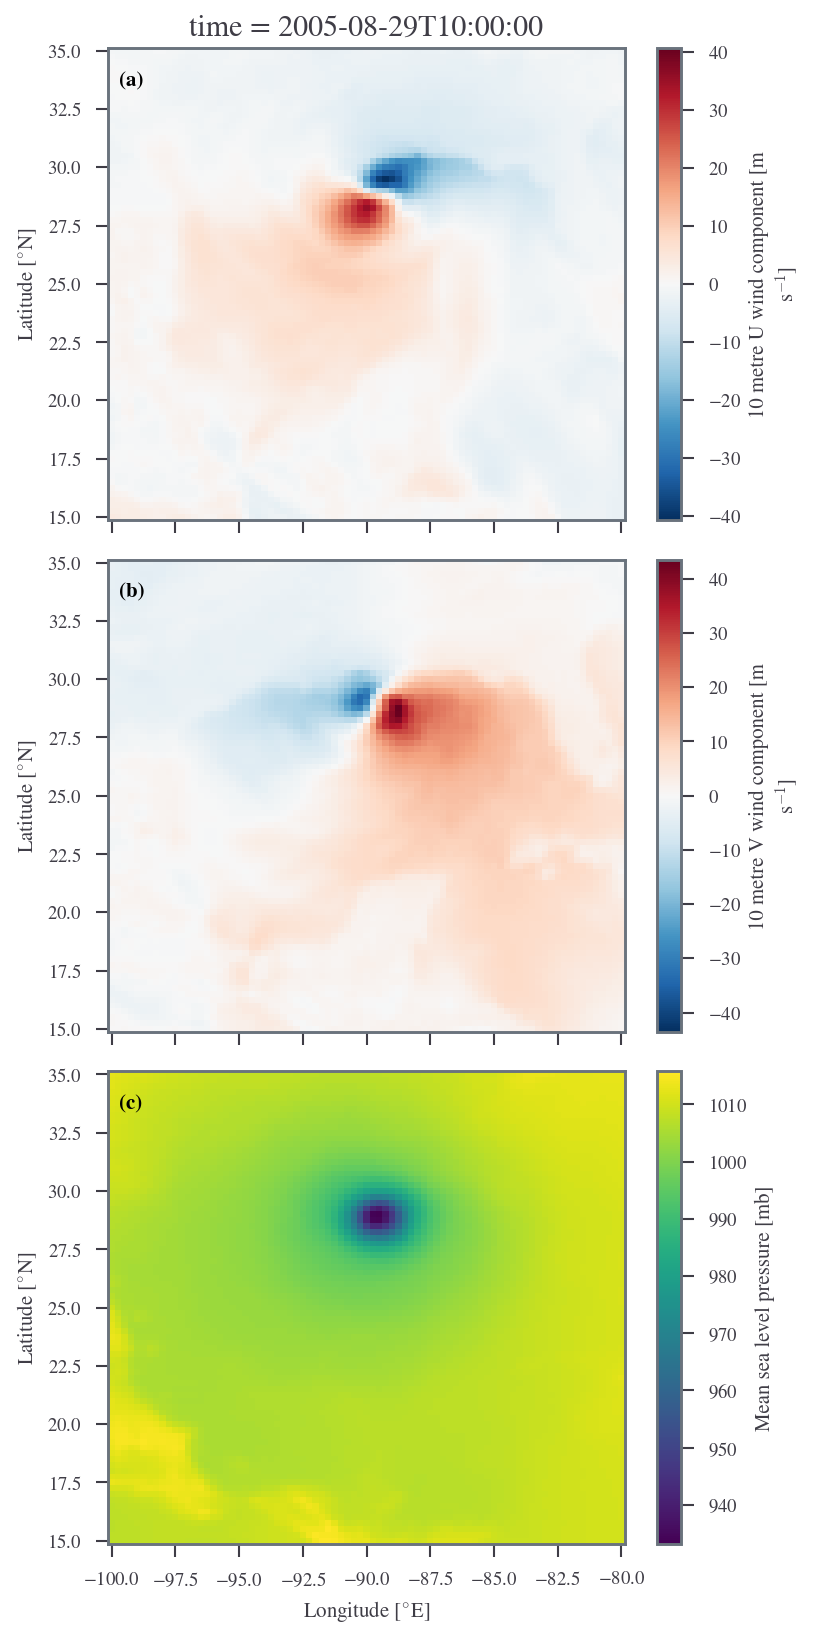

In [102]:
e5 = plot_units(xr.open_dataset(KATRINA_ERA5_NC))
fig, axs = plt.subplots(3, 1, sharex=True, figsize=get_dim(ratio=2))
mid_katrina(e5.u10).plot(ax=axs[0])
axs[0].set_xlabel("")
mid_katrina(e5.v10).plot(ax=axs[1])
axs[1].set_title("")
axs[1].set_xlabel("")
pres = mid_katrina(e5.msl)
pres[:] = pascal_to_millibar(pres.values)
pres.attrs["units"] = "mb"
pres.plot(ax=axs[2])
axs[2].set_title("")
label_subplots(axs)

## Compare time axes

In [103]:
from src.constants import DATA_PATH

In [177]:
dsp = xr.open_dataset(os.path.join(DATA_PATH, "fort.221.nc"))
dsp

<xarray.Dataset>
Dimensions:                        (lon: 100, lat: 100, time: 56)
Coordinates:
  * lon                            (lon) float64 -99.0 -98.75 ... -74.5 -74.25
  * lat                            (lat) float64 17.0 17.25 17.5 ... 41.5 41.75
  * time                           (time) datetime64[ns] 2005-08-25 ... 2005-...
Data variables:
    __xarray_dataarray_variable__  (time, lat, lon) float64 ...

In [106]:
dsw = xr.open_dataset(os.path.join(DATA_PATH, "fort.222.nc"))
dsw

<xarray.Dataset>
Dimensions:  (time: 56, lat: 100, lon: 100)
Coordinates:
  * lon      (lon) float64 -99.0 -98.75 -98.5 -98.25 ... -74.75 -74.5 -74.25
  * lat      (lat) float64 17.0 17.25 17.5 17.75 18.0 ... 41.0 41.25 41.5 41.75
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    U10      (time, lat, lon) float64 ...
    V10      (time, lat, lon) float64 ...
Attributes:
    description:  Velocities could be the wrong way round
    grid_var:     {'iLat': 100.0, 'iLong': 100.0, 'DX': 0.25, 'DY': 0.25, 'SW...

In [107]:
dsw.time

<xarray.DataArray 'time' (time: 56)>
array(['2005-08-25T00:00:00.000000000', '2005-08-25T03:00:00.000000000',
       '2005-08-25T06:00:00.000000000', '2005-08-25T09:00:00.000000000',
       '2005-08-25T12:00:00.000000000', '2005-08-25T15:00:00.000000000',
       '2005-08-25T18:00:00.000000000', '2005-08-25T21:00:00.000000000',
       '2005-08-26T00:00:00.000000000', '2005-08-26T03:00:00.000000000',
       '2005-08-26T06:00:00.000000000', '2005-08-26T09:00:00.000000000',
       '2005-08-26T12:00:00.000000000', '2005-08-26T15:00:00.000000000',
       '2005-08-26T18:00:00.000000000', '2005-08-26T21:00:00.000000000',
       '2005-08-27T00:00:00.000000000', '2005-08-27T03:00:00.000000000',
       '2005-08-27T06:00:00.000000000', '2005-08-27T09:00:00.000000000',
       '2005-08-27T12:00:00.000000000', '2005-08-27T15:00:00.000000000',
       '2005-08-27T18:00:00.000000000', '2005-08-27T21:00:00.000000000',
       '2005-08-28T00:00:00.000000000', '2005-08-28T03:00:00.000000000',
       '2005-08-28T06:00:00.000000000', '2005-08-28T09:00:00.000000000',
       '2005-08-28T12:00:00.000000000', '2005-08-28T15:00:00.000000000',
       '2005-08-28T18:00:00.000000000', '2005-08-28T21:00:00.000000000',
       '2005-08-29T00:00:00.000000000', '2005-08-29T03:00:00.000000000',
       '2005-08-29T06:00:00.000000000', '2005-08-29T09:00:00.000000000',
       '2005-08-29T12:00:00.000000000', '2005-08-29T15:00:00.000000000',
       '2005-08-29T18:00:00.000000000', '2005-08-29T21:00:00.000000000',
       '2005-08-30T00:00:00.000000000', '2005-08-30T03:00:00.000000000',
       '2005-08-30T06:00:00.000000000', '2005-08-30T09:00:00.000000000',
       '2005-08-30T12:00:00.000000000', '2005-08-30T15:00:00.000000000',
       '2005-08-30T18:00:00.000000000', '2005-08-30T21:00:00.000000000',
       '2005-08-31T00:00:00.000000000', '2005-08-31T03:00:00.000000000',
       '2005-08-31T06:00:00.000000000', '2005-08-31T09:00:00.000000000',
       '2005-08-31T12:00:00.000000000', '2005-08-31T15:00:00.000000000',
       '2005-08-31T18:00:00.000000000', '2005-08-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00

In [111]:
e5 = xr.open_dataset(KATRINA_ERA5_NC)
e5.time

<xarray.DataArray 'time' (time: 408)>
array(['2005-08-20T00:00:00.000000000', '2005-08-20T01:00:00.000000000',
       '2005-08-20T02:00:00.000000000', ..., '2005-09-05T21:00:00.000000000',
       '2005-09-05T22:00:00.000000000', '2005-09-05T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-08-20 ... 2005-09-05T23:00:00
Attributes:
    long_name:  time

In [114]:
e5.sel(time=slice("2005-08-25", "2005-08-31"))

<xarray.Dataset>
Dimensions:    (longitude: 81, latitude: 81, time: 168)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -80.5 -80.25 -80.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2005-08-25 ... 2005-08-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-28 16:29:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [130]:
ca = (
    e5[["msl", "u10", "v10"]]
    .sel(time=slice("2005-08-24T23", "2005-08-31T22"))
    .coarsen(time=3)
    .mean()
)
ca

<xarray.Dataset>
Dimensions:    (time: 56, latitude: 81, longitude: 81)
Coordinates:
  * longitude  (longitude) float32 -100.0 -99.75 -99.5 ... -80.5 -80.25 -80.0
  * latitude   (latitude) float32 35.0 34.75 34.5 34.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    msl        (time, latitude, longitude) float32 1.011e+05 ... 1.009e+05
    u10        (time, latitude, longitude) float32 -2.273 -1.378 ... -5.111
    v10        (time, latitude, longitude) float32 3.977 3.643 ... -2.138 -2.276
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-28 16:29:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [131]:
ca.time

<xarray.DataArray 'time' (time: 56)>
array(['2005-08-25T00:00:00.000000000', '2005-08-25T03:00:00.000000000',
       '2005-08-25T06:00:00.000000000', '2005-08-25T09:00:00.000000000',
       '2005-08-25T12:00:00.000000000', '2005-08-25T15:00:00.000000000',
       '2005-08-25T18:00:00.000000000', '2005-08-25T21:00:00.000000000',
       '2005-08-26T00:00:00.000000000', '2005-08-26T03:00:00.000000000',
       '2005-08-26T06:00:00.000000000', '2005-08-26T09:00:00.000000000',
       '2005-08-26T12:00:00.000000000', '2005-08-26T15:00:00.000000000',
       '2005-08-26T18:00:00.000000000', '2005-08-26T21:00:00.000000000',
       '2005-08-27T00:00:00.000000000', '2005-08-27T03:00:00.000000000',
       '2005-08-27T06:00:00.000000000', '2005-08-27T09:00:00.000000000',
       '2005-08-27T12:00:00.000000000', '2005-08-27T15:00:00.000000000',
       '2005-08-27T18:00:00.000000000', '2005-08-27T21:00:00.000000000',
       '2005-08-28T00:00:00.000000000', '2005-08-28T03:00:00.000000000',
       '2005-08-28T06:00:00.000000000', '2005-08-28T09:00:00.000000000',
       '2005-08-28T12:00:00.000000000', '2005-08-28T15:00:00.000000000',
       '2005-08-28T18:00:00.000000000', '2005-08-28T21:00:00.000000000',
       '2005-08-29T00:00:00.000000000', '2005-08-29T03:00:00.000000000',
       '2005-08-29T06:00:00.000000000', '2005-08-29T09:00:00.000000000',
       '2005-08-29T12:00:00.000000000', '2005-08-29T15:00:00.000000000',
       '2005-08-29T18:00:00.000000000', '2005-08-29T21:00:00.000000000',
       '2005-08-30T00:00:00.000000000', '2005-08-30T03:00:00.000000000',
       '2005-08-30T06:00:00.000000000', '2005-08-30T09:00:00.000000000',
       '2005-08-30T12:00:00.000000000', '2005-08-30T15:00:00.000000000',
       '2005-08-30T18:00:00.000000000', '2005-08-30T21:00:00.000000000',
       '2005-08-31T00:00:00.000000000', '2005-08-31T03:00:00.000000000',
       '2005-08-31T06:00:00.000000000', '2005-08-31T09:00:00.000000000',
       '2005-08-31T12:00:00.000000000', '2005-08-31T15:00:00.000000000',
       '2005-08-31T18:00:00.000000000', '2005-08-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Attributes:
    long_name:  time

In [133]:
assert np.all(dsw.time.values == ca.time.values)

## Change ERA5 to ADCIRC Input

In [137]:
ca[["u10", "v10"]].rename(
    {"u10": "U10", "v10": "V10", "longitude": "lon", "latitude": "lat"}
)

<xarray.Dataset>
Dimensions:  (time: 56, lat: 81, lon: 81)
Coordinates:
  * lon      (lon) float32 -100.0 -99.75 -99.5 -99.25 ... -80.5 -80.25 -80.0
  * lat      (lat) float32 35.0 34.75 34.5 34.25 34.0 ... 15.75 15.5 15.25 15.0
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    U10      (time, lat, lon) float32 -2.273 -1.378 -0.7423 ... -4.836 -5.111
    V10      (time, lat, lon) float32 3.977 3.643 3.678 ... -1.955 -2.138 -2.276
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-28 16:29:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [139]:
print(dsw.lat.min(), dsw.lat.max(), dsw.lon.min(), dsw.lon.max())

<xarray.DataArray 'lat' ()>
array(17.) <xarray.DataArray 'lat' ()>
array(41.75) <xarray.DataArray 'lon' ()>
array(-99.) <xarray.DataArray 'lon' ()>
array(-74.25)


In [140]:
from sithom.place import BoundingBox

In [144]:
bbox = BoundingBox(
    lon=[-99, -74.25], lat=[17, 41.75], desc="Katrina Example Input Bounds"
)
bbox

[('Latitude bounds', [17, 41.75], 'degrees_north'), ('Longitude bounds', [-99, -74.25], 'degrees_east'), 'Katrina Example Input Bounds']

In [145]:
bbox.ecmwf()

[41.75, -99, 17, -74.25]

In [149]:
def add_padding(bb: BoundingBox, padding=0.5) -> BoundingBox:
    return BoundingBox(
        lon=[bb.lon[0] - padding, bb.lon[1] + padding],
        lat=[bb.lat[0] - padding, bb.lat[1] + padding],
        desc=bb.desc,
    )

In [151]:
add_padding(bbox).ecmwf()

[42.25, -99.5, 16.5, -73.75]

In [152]:
from src.data_loading.ecmwf import katrina_example_netcdf

In [159]:
katrina_example_netcdf(file_name=os.path.join(DATA_PATH, "katrina_example_input.nc"))

2022-10-15 16:11:56,289 INFO Welcome to the CDS
2022-10-15 16:11:56,290 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-10-15 16:11:56,432 INFO Request is completed
2022-10-15 16:11:56,434 INFO Downloading https://download-0004-clone.copernicus-climate.eu/cache-compute-0004/cache/data6/adaptor.mars.internal-1665846485.6683438-8300-16-e6c2c507-699c-42ae-b417-cb11c31a859c.nc to /Users/simon/new-orleans/data/katex-0.nc (11.9M)
2022-10-15 16:12:02,063 INFO Download rate 2.1M/s                                                                                    


In [158]:
! rm /Users/simon/new-orleans/data/katrina_example_input.nc

In [164]:
from sithom.xr import mon_increase

In [167]:
e5e = mon_increase(
    xr.open_dataset(os.path.join(DATA_PATH, "katrina_example_input.nc")),
    x_dim="lon",
    y_dim="lat",
)
e5e

<xarray.Dataset>
Dimensions:  (lon: 104, lat: 104, time: 56)
Coordinates:
  * lon      (lon) float32 -99.5 -99.25 -99.0 -98.75 ... -74.25 -74.0 -73.75
  * lat      (lat) float32 16.5 16.75 17.0 17.25 17.5 ... 41.5 41.75 42.0 42.25
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    U10      (time, lat, lon) float32 ...
    V10      (time, lat, lon) float32 ...
    pres     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-15 15:08:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [173]:
dsw

<xarray.Dataset>
Dimensions:  (time: 56, lat: 100, lon: 100)
Coordinates:
  * lon      (lon) float64 -99.0 -98.75 -98.5 -98.25 ... -74.75 -74.5 -74.25
  * lat      (lat) float64 17.0 17.25 17.5 17.75 18.0 ... 41.0 41.25 41.5 41.75
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    U10      (time, lat, lon) float64 0.0 0.0 0.0 0.0 ... 2.699 2.395 1.645
    V10      (time, lat, lon) float64 ...
Attributes:
    description:  Velocities could be the wrong way round
    grid_var:     {'iLat': 100.0, 'iLong': 100.0, 'DX': 0.25, 'DY': 0.25, 'SW...

In [171]:
dsw.U10.values.shape

(56, 100, 100)

In [172]:
e5e.U10.values.shape

(56, 104, 104)

In [197]:
e5e = mon_increase(
    xr.open_dataset(os.path.join(DATA_PATH, "katrina_example_input.nc")),
    x_dim="lon",
    y_dim="lat",
)
ce5e = e5e.sel(lon=slice(-99, -74.25), lat=slice(17, 41.75))
ce5e["pres"][:] = pascal_to_millibar(ce5e["pres"].values)
ce5e["pres"].attrs["units"] = "mb"

In [191]:
ce5e[["U10", "V10"]]

<xarray.Dataset>
Dimensions:  (time: 56, lat: 100, lon: 100)
Coordinates:
  * lon      (lon) float32 -99.0 -98.75 -98.5 -98.25 ... -74.75 -74.5 -74.25
  * lat      (lat) float32 17.0 17.25 17.5 17.75 18.0 ... 41.0 41.25 41.5 41.75
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    U10      (time, lat, lon) float32 -0.4663 -0.3992 -0.4498 ... 3.258 2.992
    V10      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-15 15:08:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [199]:
ce5e[["pres"]]

<xarray.Dataset>
Dimensions:  (time: 56, lat: 100, lon: 100)
Coordinates:
  * lon      (lon) float32 -99.0 -98.75 -98.5 -98.25 ... -74.75 -74.5 -74.25
  * lat      (lat) float32 17.0 17.25 17.5 17.75 18.0 ... 41.0 41.25 41.5 41.75
  * time     (time) datetime64[ns] 2005-08-25 ... 2005-08-31T21:00:00
Data variables:
    pres     (time, lat, lon) float32 1.013e+03 1.013e+03 ... 998.9 998.2
Attributes:
    Conventions:  CF-1.6
    history:      2022-10-15 15:08:06 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [198]:
print_wsp(ce5e[["U10", "V10"]], os.path.join(DATA_PATH, "katex.fort.222"))
print_pressure(ce5e["pres"], os.path.join(DATA_PATH, "katex.fort.221"))

In [188]:
?print_wsp

## Check new input files

In [ ]:
from src.data_loading.adcirc import (
    print_wsp,
    print_pressure,
    read_windspeeds,
    read_pressures,
)

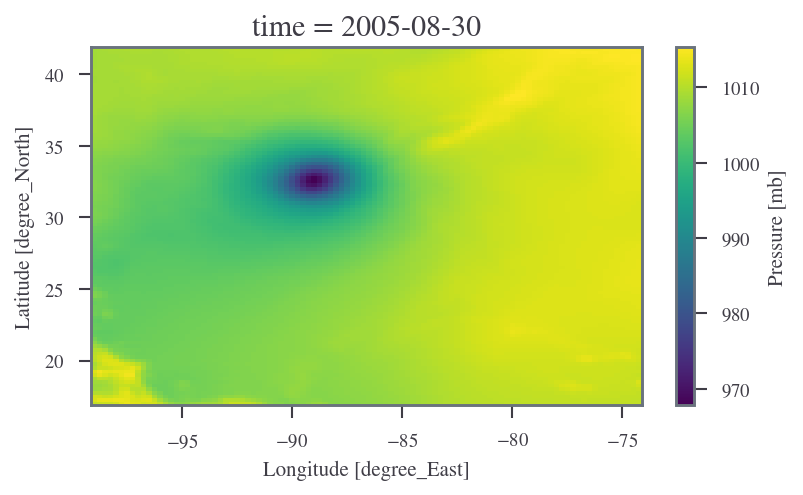

In [201]:
read_pressures(os.path.join(DATA_PATH, "katex.fort.221")).isel(time=40).plot()

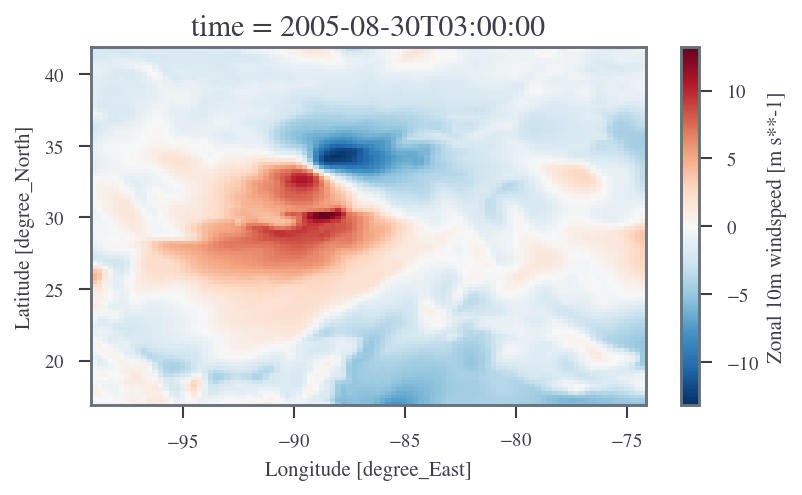

In [207]:
u10_exp = read_windspeeds(os.path.join(DATA_PATH, "katex.fort.222")).U10.isel(time=41)
u10_exp.plot()

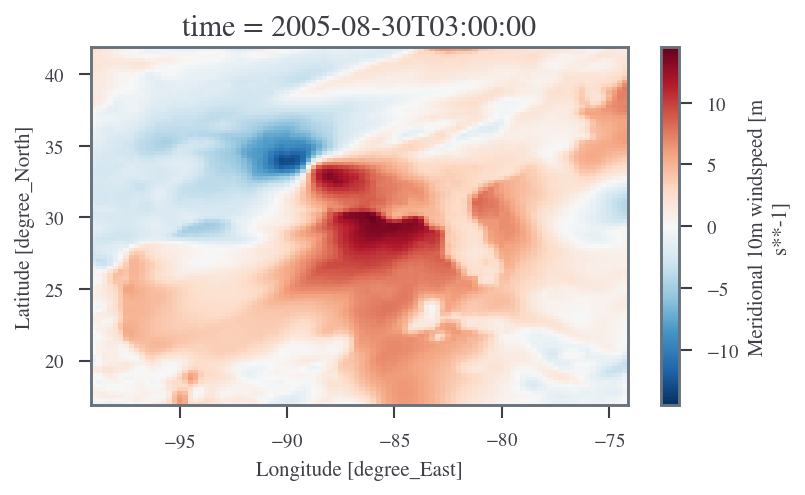

In [206]:
read_windspeeds(os.path.join(DATA_PATH, "katex.fort.222")).V10.isel(time=41).plot()

## Make inputs and run

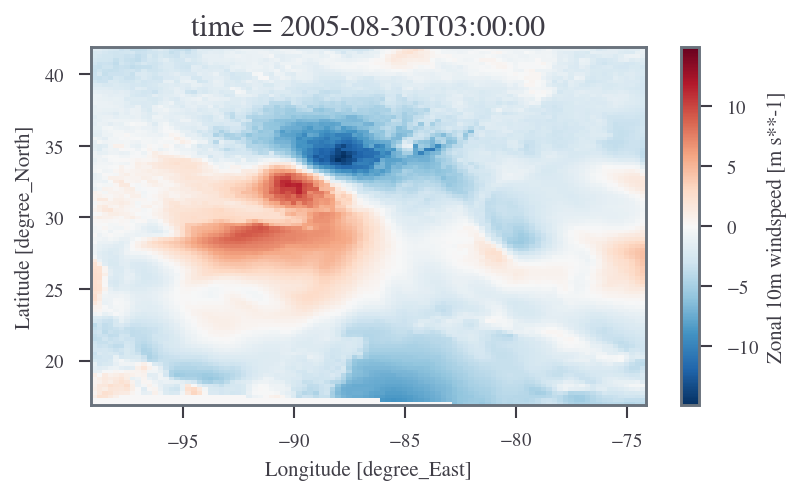

In [213]:
dsw.U10.isel(time=41).plot()

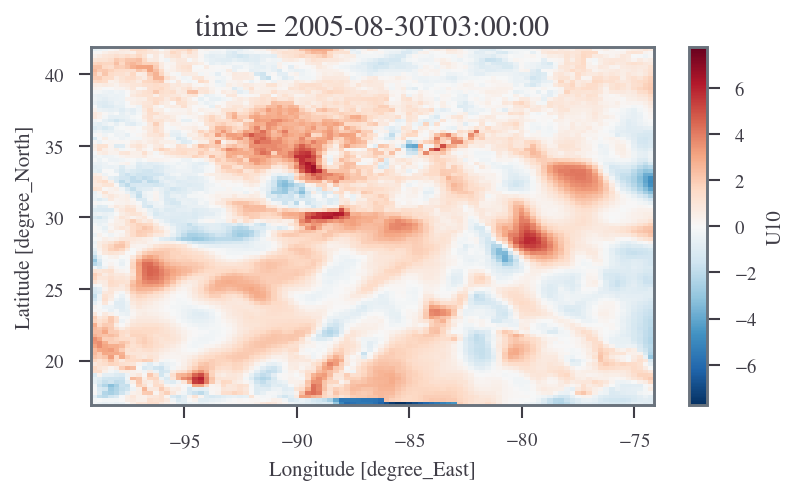

In [214]:
(u10_exp - dsw.U10.isel(time=41)).plot()

## Verification